In [1]:
import time, psutil, os
_proc = psutil.Process(os.getpid())
_start_time = time.time()
_start_mem = _proc.memory_info().rss


# 1D CNN K-Fold Pipeline
This notebook trains a lightweight 1‑Dimensional CNN to detect SYN‑flood traffic.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns


## Load dataset

In [3]:
CSV_PATH = 'K5_Dataset.csv'  # change if needed
df = pd.read_csv(CSV_PATH)
features = [c for c in df.columns if c not in ('Label', 'Fold')]

Mounted at /content/drive


## Build CNN model function

In [4]:
def build_cnn(input_shape):
    m = Sequential([
        Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(), MaxPooling1D(2),
        Conv1D(64, 5, activation='relu', padding='same'),
        BatchNormalization(), GlobalAveragePooling1D(),
        Dropout(0.2), Dense(64, activation='relu'), Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

## Cross‑validation loop

In [5]:
folds = sorted(df['Fold'].unique())
accs, cms = [], None
for fid in folds:
    train = df[df['Fold'] != fid]
    test  = df[df['Fold'] == fid]
    X_tr, y_tr = train[features], train['Label']
    X_te, y_te = test[features],  test['Label']
    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)[..., None]
    X_te = scaler.transform(X_te)[..., None]
    model = build_cnn((X_tr.shape[1], 1))
    model.fit(X_tr, y_tr, epochs=10, batch_size=64, verbose=0, validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
    accs.append(model.evaluate(X_te, y_te, verbose=0)[1])
    y_pred = (model.predict(X_te, verbose=0) > 0.5).astype(int)
    cm = confusion_matrix(y_te, y_pred)
    cms = cm if cms is None else cms + cm
print(f"Mean accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Mean accuracy: 0.9982 ± 0.0010


## Confusion matrix

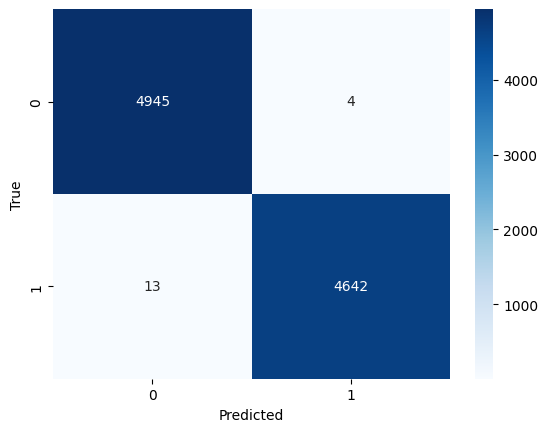

In [6]:
sns.heatmap(cms, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

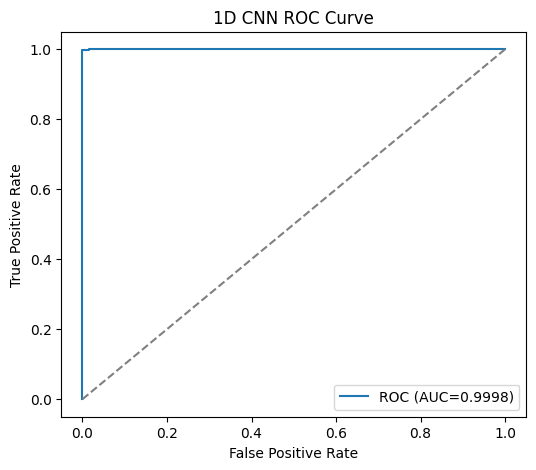

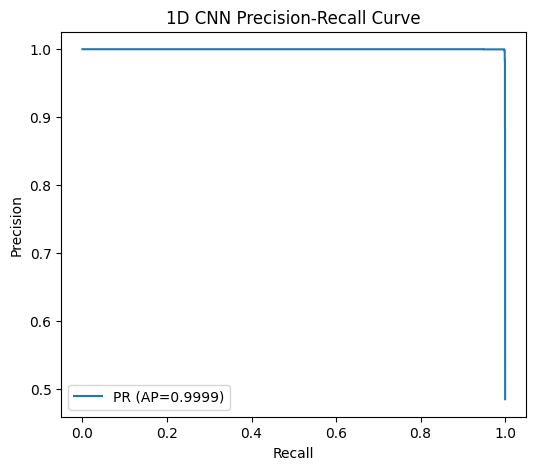

In [7]:

# ---- Aggregate ROC & PR across folds ----
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc

all_true, all_prob = [], []
for fid in folds:
    part_mask = df['Fold'] == fid
    X_te = df.loc[part_mask, features]
    y_te = df.loc[part_mask, 'Label']
    X_te_scaled = scaler.transform(X_te)[..., None]
    preds = model.predict(X_te_scaled, verbose=0).ravel()
    all_true.extend(y_te)
    all_prob.extend(preds)

fpr, tpr, _ = roc_curve(all_true, all_prob)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(all_true, all_prob)
ap = average_precision_score(all_true, all_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('1D CNN ROC Curve'); plt.legend(); plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR (AP={ap:.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('1D CNN Precision-Recall Curve'); plt.legend(); plt.show()


In [8]:
_end_mem = _proc.memory_info().rss
print("\nOverall Training Stats")
print(f"Total Training Time: {time.time() - _start_time:.2f} seconds")
print(f"Total RAM Usage Increase: {(_end_mem - _start_mem)/(1024**2):.2f} MB")
print(f"CPU Usage (at final check): {psutil.cpu_percent(interval=1):.1f}%")

print("\nFinal CNN Cross‑Validation Results:")
print(f"Fold Accuracies: {accs}")
print(f"Mean Accuracy: {np.mean(accs):.4f}")
print(f"Standard Deviation: {np.std(accs):.4f}")



Overall Training Stats
Total Training Time: 173.77 seconds
Total RAM Usage Increase: 806.77 MB
CPU Usage (at final check): 4.0%

Final CNN Cross‑Validation Results:
Fold Accuracies: [1.0, 0.99843829870224, 0.9973971843719482, 0.9973971843719482, 0.9979166388511658]
Mean Accuracy: 0.9982
Standard Deviation: 0.0010
